In [197]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col, array_contains, avg, kurtosis, mean, skewness, stddev, variance,round,lit

# Get or instantiate a SparkContext and register it as a singleton object
sc = SparkSession.builder.appName('adq').getOrCreate()

In [198]:
# DataFrame created by reading a csv file

delimiter = ","

df = sc.read.format("csv").option("inferSchema", True).option("header", True).option("sep", delimiter).load("TSLA.csv")

df.printSchema()
df.show()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)

+----------+---------+---------+---------+---------+---------+--------+
|      Date|     Open|     High|      Low|    Close|Adj Close|  Volume|
+----------+---------+---------+---------+---------+---------+--------+
|2010-06-29|     19.0|     25.0|17.540001|23.889999|23.889999|18766300|
|2010-06-30|25.790001|    30.42|23.299999|    23.83|    23.83|17187100|
|2010-07-01|     25.0|    25.92|    20.27|21.959999|21.959999| 8218800|
|2010-07-02|     23.0|     23.1|18.709999|19.200001|19.200001| 5139800|
|2010-07-06|     20.0|     20.0|    15.83|16.110001|16.110001| 6866900|
|2010-07-07|     16.4|16.629999|    14.98|     15.8|     15.8| 6921700|
|2010-07-08|16.139999|    17.52|    15.57|17.459999|17.459999| 7711400|
|2010-07-09|  

# Data Science PySpark Notebook
---


In [199]:
df.describe().show()

+-------+----------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|      Date|              Open|              High|               Low|             Close|         Adj Close|           Volume|
+-------+----------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|      2416|              2416|              2416|              2416|              2416|              2416|             2416|
|   mean|      null| 186.2711466001655|189.57822425620878|182.91663908236822|186.40365078187054|186.40365078187054|5572721.688741722|
| stddev|      null|118.74016318157156|120.89232871387047|116.85759099326675|119.13601997634154|119.13601997634154|4987809.151888422|
|    min|2010-06-29|         16.139999|         16.629999|             14.98|              15.8|              15.8|           118500|
|    max|2020-02-03|        673.690002|        786.140015|    

In [200]:
# Lambda functions

import functools

names = df.schema.names

print(list(filter(lambda arg: len(arg) > 3, names)))
print(list(map(lambda arg: arg.upper(), names)))

x = []
for name in names:
    x.append(name.upper())
print(x)


['Date', 'Open', 'High', 'Close', 'Adj Close', 'Volume']
['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ CLOSE', 'VOLUME']
['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ CLOSE', 'VOLUME']


In [201]:
# List of columns without string data

numeric_columns = [i[0] for i in df.dtypes if i[1] != 'string']

# kurtosis calculation for all columns in a DataFrame

def kurtosis_calc(to_calc_columns):
    kurtosis_df = df.select([kurtosis(col(df_col)).alias(df_col) for df_col in to_calc_columns])
    kurtosis_df = kurtosis_df.select([round(col(df_col), 3).alias(df_col) for df_col in to_calc_columns])
    kurtosis_df = kurtosis_df.withColumn("Metric", lit("Kurtosis"))
    kurtosis_df = kurtosis_df.select(["Metric"]+to_calc_columns)
    return kurtosis_df

kurtosis_df = kurtosis_calc(numeric_columns)


In [202]:
# variance calculation for all columns in a DataFrame

def variance_calc(to_calc_columns):    
    variance_df = df.select([variance(col(df_col)).alias(df_col) for df_col in to_calc_columns])
    variance_df = variance_df.select([round(col(df_col), 3).alias(df_col) for df_col in to_calc_columns])
    variance_df = variance_df.withColumn("Metric", lit("Variance"))
    variance_df = variance_df.select(["Metric"]+to_calc_columns)
    return variance_df

variance_df = variance_calc(numeric_columns)

In [203]:
# skewness calculation for all columns in a DataFrame

def skewness_calc(to_calc_columns):
    skewness_df = df.select([skewness(col(df_col)).alias(df_col) for df_col in to_calc_columns])
    skewness_df = skewness_df.select([round(col(df_col), 3).alias(df_col) for df_col in to_calc_columns])
    skewness_df = skewness_df.withColumn("Metric", lit("Skewness"))
    skewness_df = skewness_df.select(["Metric"]+to_calc_columns)
    return skewness_df

skewness_df = skewness_calc(numeric_columns)

In [204]:
# stddev calculation for all columns in a DataFrame

def stddev_calc(to_calc_columns):
    stddev_df = df.select([stddev(col(df_col)).alias(df_col) for df_col in numeric_columns])
    stddev_df = stddev_df.select([round(col(df_col), 3).alias(df_col) for df_col in numeric_columns])
    stddev_df = stddev_df.withColumn("Metric", lit("Stddev"))
    stddev_df = stddev_df.select(["Metric"]+to_calc_columns)
    return stddev_df

stddev_df = stddev_calc(numeric_columns)

In [205]:
# quartile approximation for all columns in a DataFrame

def quartile_calc(to_calc_columns):
    quartile_df = df.select(numeric_columns).summary("25%", "75%")
    quartile_df = quartile_df.select([round(col(df_col), 3).alias(df_col) for df_col in to_calc_columns])
    quartile_df = quartile_df.withColumn("Metric", lit("Quartile"))
    quartile_df = quartile_df.select(["Metric"]+to_calc_columns)
    return quartile_df

quartile_df = quartile_calc(numeric_columns)

In [206]:
summary_df = kurtosis_df.union(stddev_df).union(variance_df).union(skewness_df).union(quartile_df)
summary_df.show()

+--------+---------+---------+---------+---------+---------+-------------------+
|  Metric|     Open|     High|      Low|    Close|Adj Close|             Volume|
+--------+---------+---------+---------+---------+---------+-------------------+
|Kurtosis|    -0.73|   -0.585|   -0.724|   -0.577|   -0.577|               7.41|
|  Stddev|   118.74|  120.892|  116.858|  119.136|  119.136|        4987809.152|
|Variance|14099.226|14614.955|13655.697|14193.391|14193.391|2.48782401356619E13|
|Skewness|   -0.014|    0.012|    -0.01|    0.017|    0.017|              2.164|
|Quartile|    34.32|    34.89|    33.58|     34.4|     34.4|          1893200.0|
|Quartile|   266.45|   270.92|    262.1|   266.77|   266.77|          7361100.0|
+--------+---------+---------+---------+---------+---------+-------------------+



In [207]:
from pyspark.sql.functions import to_json
# What does the collect/select method do

summary_json = summary_df.toJSON().collect()
print(summary_json)


['{"Metric":"Kurtosis","Open":-0.73,"High":-0.585,"Low":-0.724,"Close":-0.577,"Adj Close":-0.577,"Volume":7.41}', '{"Metric":"Stddev","Open":118.74,"High":120.892,"Low":116.858,"Close":119.136,"Adj Close":119.136,"Volume":4987809.152}', '{"Metric":"Variance","Open":14099.226,"High":14614.955,"Low":13655.697,"Close":14193.391,"Adj Close":14193.391,"Volume":2.48782401356619E13}', '{"Metric":"Skewness","Open":-0.014,"High":0.012,"Low":-0.01,"Close":0.017,"Adj Close":0.017,"Volume":2.164}', '{"Metric":"Quartile","Open":34.32,"High":34.89,"Low":33.58,"Close":34.4,"Adj Close":34.4,"Volume":1893200.0}', '{"Metric":"Quartile","Open":266.45,"High":270.92,"Low":262.1,"Close":266.77,"Adj Close":266.77,"Volume":7361100.0}']


In [208]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np # Linear Algebra
import pandas as pd # Data Processing


1    2174
-1     242
Name: anomaly, dtype: int64


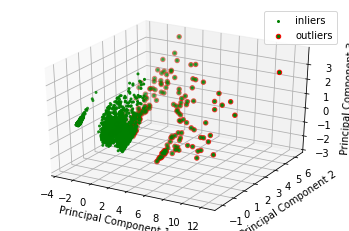

In [209]:
np.random.seed(42)

df = df[numeric_columns].toPandas()

# Isolation Forest is the classifier
clf = IsolationForest(n_estimators=100, contamination=.1, max_samples='auto', max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)

clf.fit(df)

pred = clf.predict(df)
df['anomaly'] = pred
outliers = df.loc[df['anomaly'] == -1]
outlier_index=list(outliers.index)

print(df['anomaly'].value_counts())

pca = PCA(n_components=3) # Reduce to k=3 dimensions
scaler = StandardScaler()

# Normalize the metrics

X = scaler.fit_transform(df)
X_reduce = pca.fit_transform(X)
principalDF = pd.DataFrame(data=X_reduce, columns=['principal component 1', 'principal component 2', 'principal component 3'])


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# Plot the compressed data points

ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers", c="green")

# Plot x's for the ground truth outliers

ax.scatter(X_reduce[outlier_index, 0], X_reduce[outlier_index, 1], X_reduce[outlier_index, 2], lw=1, s=20, edgecolor="red", c="green", label="outliers")

ax.legend()
plt.show()

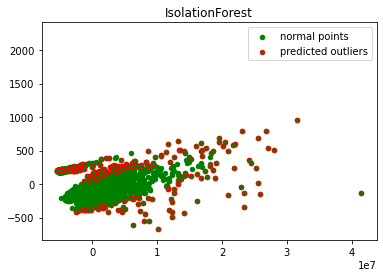

In [210]:
pca = PCA(2)
pca.fit(df[to_model_columns])

res = pd.DataFrame(pca.transform(df[to_model_columns]))

Z = np.array(res)

plt.title("IsolationForest")
plt.contourf(Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(res[0], res[1], c='green', s=20,label="normal points")

b1 = plt.scatter(res.iloc[outlier_index,0], res.iloc[outlier_index,1], c='green', s=20, edgecolor="red", label="predicted outliers")

plt.legend(loc="upper right")
plt.show()